<a href="https://colab.research.google.com/github/Buyan-Kirill/practice-VTM-sem-8/blob/main/Tensors_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\Large{Maxvol}$  $\Large{with}$  $\Large{cache}$

In [1]:
from logging import exception
import numpy as np
import time
import random
import scipy
import math
import matplotlib.pyplot as plt

true_errors = []
estimations = []
sizes = []


In [2]:
class Maxvol_approx:
    def __init__(self, A: np.ndarray):
        if len(A.shape) == 2:
            self.A = A
            # использованные строки и столбцы
            self.V = [] # строки
            self.U = [] # столбцы
            # запоминать посещённые, но не использованные строки
            self.visited_R = {}
            self.visited_C = {}
            # индексы этих строк
            self.unused_R_ind = set([i for i in range(A.shape[0])])
            self.unused_C_ind = set([i for i in range(A.shape[1])])
        else:
            raise ValueError('A must has numpy.ndarray type with 2 dimensions')

    def __str__(self):
        return str(self.A)

    # Нахождение элеманта с учётом матриц U, V
    def __getitem__(self, indexes):
        i, j = indexes
        a_ij = self.A[i, j]
        for k in range(len(self.V)):
            a_ij -= self.U[k][i] * self.V[k][j]
        return a_ij

    # Размеры
    @property
    def shape(self):
        return self.A.shape

    # Нахождение строки с учётом матриц U, V
    def get_row(self, i):
        a_row = self.A[i, :].copy()
        for k in range(len(self.V)):
            a_row -= self.U[k][i] * self.V[k]
        return a_row

    # Нахождение столбца с учётом матриц U, V
    def get_column(self, j):
        a_col = self.A[:, j].copy()
        for k in range(len(self.V)):
            a_col -= self.U[k] * self.V[k][j]
        return a_col

    # Нахождение максимумов у сохранённых C, R
    def find_CR_argmaxes(self):
        r_max = 0
        i_r, j_r = 0, 0
        for i, row in self.visited_R.items():
            j_argmax = np.argmax(abs(row))
            if abs(row[j_argmax]) >= r_max:
                i_r = i
                j_r = j_argmax
                r_max = abs(row[j_argmax])

        c_max = 0
        i_c, j_c = 0, 0
        for j, column in self.visited_C.items():
            i_argmax = np.argmax(abs(column))
            if abs(column[i_argmax]) >= c_max:
                i_c = i_argmax
                j_c = j
                c_max = abs(column[i_argmax])

        return i_r, j_r, r_max, i_c, j_c, c_max

    # Итрации maxvol
    def maxvol(self, i, j, steps = 4):
        for k in range(steps // 2):
            row = self.get_row(i)
            j = np.argmax(abs(row))
            if i not in list(self.visited_R.keys()):
                self.visited_R[i] = row

            column = self.get_column(j)
            i = np.argmax(abs(column))
            if j not in list(self.visited_C.keys()):
                self.visited_C[j] = column
        if steps % 2 == 1:
            row = self.get_row(i)
            j = np.argmax(abs(row))
            if i not in list(self.visited_R.keys()):
                self.visited_R[i] = row
        return i, j

    # Изменить матрицы CR
    def correct_CR(self):
        for i, row in self.visited_R.items():
            row -= self.U[-1][i] * self.V[-1]

        for j, column in self.visited_C.items():
            column -= self.U[-1] * self.V[-1][j]

    # Один шаг при аппоксимации
    def cross_step(self):
        i, j = np.random.choice(tuple(self.unused_R_ind)), np.random.choice(tuple(self.unused_C_ind))
        if not (i in self.visited_R.keys()):
            self.visited_R[i] = self.get_row(i)
        if not (j in self.visited_C.keys()):
            self.visited_C[j] = self.get_column(j)

        # print(self.visited_C)

        i_r, j_r, r_max, i_c, j_c, c_max = self.find_CR_argmaxes()
        if i_r == i_c and j_r == j_c:
            # print(i_c, j_c)
            if abs(self.visited_C[j_c][i_c]) < 10**-8:
                return
            u = self.visited_C[j_c] / self.visited_C[j_c][i_c]
            v = self.visited_R[i_c]
            del self.visited_C[j_c]
            del self.visited_R[i_r]
        else:
            i_start, j_start = (i_c, j_c) if r_max < c_max else (i_r, j_r)
            i_end, j_end = self.maxvol(i_start, j_start)
            u = self.get_column(j_end)
            if abs(u[i_end]) < 10**-8:
                return
            u /= u[i_end]
            v = self.get_row(i_end)

        self.U.append(u)
        self.V.append(v)
        self.correct_CR()

    # Оценка ошибки
    @property
    def error(self):
        i_r, j_r, r_max, i_c, j_c, c_max = self.find_CR_argmaxes()
        a_max = max(r_max, c_max)
        m = self.A.shape[0] - len(self.V) - len(self.visited_R)
        n = self.A.shape[1] - len(self.U) - len(self.visited_C)

        R_norm, C_norm, A_norm = 0, 0, 0
        A_i = list(self.visited_R.keys())
        for column in self.visited_C.values():
            A_norm += np.dot(column[A_i], column[A_i])
            C_norm += np.dot(column, column)
        for row in self.visited_R.values():
            R_norm += np.dot(row, row)

        return (a_max ** 2 * m * n + C_norm + R_norm - A_norm) ** 0.5

    # Реальная ошибка (для тестирования)
    @property
    def real_error(self):
        Error_norm = 0
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                Error_norm += self[i, j] ** 2
        return Error_norm ** 0.5

    # Аппроксимация матрицы
    def cross_approx(self, min_steps = 3, error=1):
        while True:
            self.cross_step()
            global estimations
            estimations += [self.error]
            global true_errors
            true_errors += [self.real_error]
            global sizes
            sizes += [len(self.U)]
            if self.error < error and min_steps <= 0:
                return
            min_steps -= 1

            m = self.A.shape[0] - len(self.V)
            n = self.A.shape[1] - len(self.U)
            if m == 0 or n == 0:
                return

In [3]:
def tester(error_line=1):
    global estimations
    global true_errors
    global sizes
    plt.plot(sizes, true_errors, label="true_error")
    plt.plot(sizes, estimations, label="estimation")
    plt.plot(sizes, [error_line] * len(sizes), label="error line")
    plt.xlabel("Size")
    plt.ylabel("Error")
    plt.legend()
    plt.show()
    true_errors = []
    estimations = []
    sizes = []

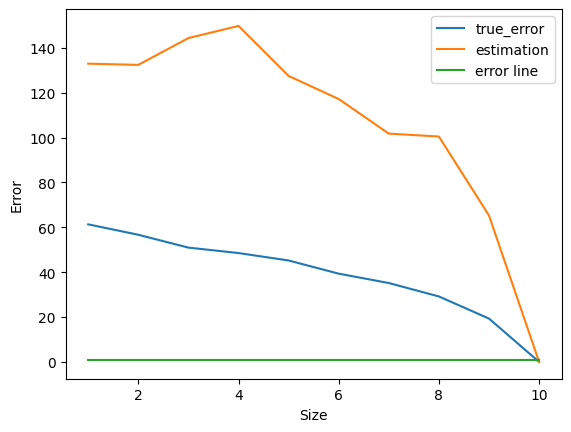

In [4]:
N = 200
np.random.seed(42)
A = np.zeros(shape=(N, N))
U = np.random.rand(N, 10)
V = np.random.rand(10, N)
A += U @ V
A = Maxvol_approx(A)
A.cross_approx()
tester()


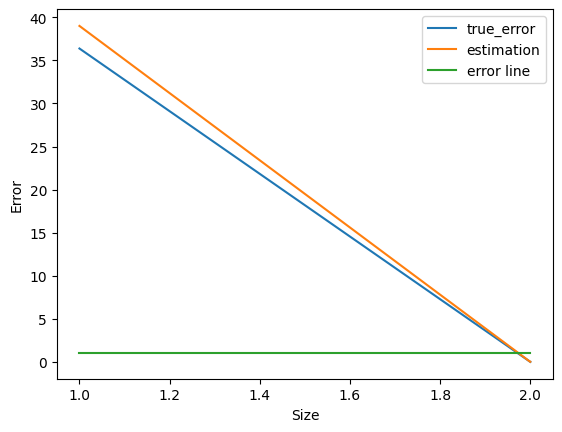

In [5]:
N = 100
A = np.zeros(shape=(N, N))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i, j] = math.sin(1 / (i + 1) + 1 / (j + 1))
A = Maxvol_approx(A)
A.cross_approx()
tester()

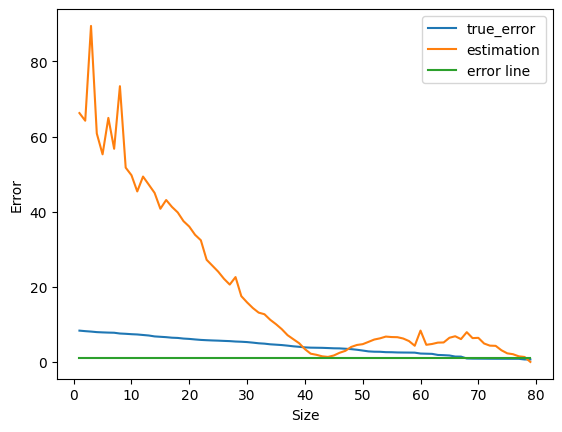

In [6]:
N = 100
A = np.zeros(shape=(N, N))
random.seed(42)
fullness = 0.02
pos = [[random.randint(0, N - 1), random.randint(0, N - 1)] for i in range(int(N**2 * fullness))]
for k in pos:
    A[k[0], k[1]] = random.random()

A = Maxvol_approx(A)
A.cross_approx()

tester()

<ipython-input-2-51d46e213c12>:144: RuntimeWarning: invalid value encountered in scalar power
  return (a_max ** 2 * m * n + C_norm + R_norm - A_norm) ** 0.5


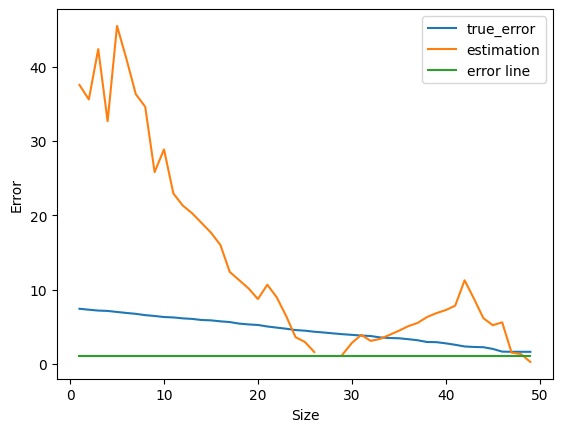

In [7]:
N = 60
A = np.zeros(shape=(N, N))
random.seed(30)
fullness = 0.05
pos = [[random.randint(0, N - 1), random.randint(0, N - 1)] for i in range(int(N**2 * fullness))]
for k in pos:
    A[k[0], k[1]] = random.random()

A = Maxvol_approx(A)
A.cross_approx()

tester()